In [1]:
import numpy as np
import pandas as pd
import os

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [1]:
import os
import numpy as np
import cv2
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import xml.etree.ElementTree as ET
from tensorflow.keras import layers, models, regularizers

# Function to load images and annotations
def load_dataset(dataset_dir):
    images_dir = os.path.join(dataset_dir, "images")
    annotations_dir = os.path.join(dataset_dir, "annotations")
    
    images = []
    labels = []
    for filename in os.listdir(annotations_dir):
        if filename.endswith(".xml"):
            xml_path = os.path.join(annotations_dir, filename)
            tree = ET.parse(xml_path)
            root = tree.getroot()
            for obj in root.findall('object'):
                label = obj.find('name').text
                label = 'with_mask' if label == 'with_mask' else 'without_mask'  # Assuming binary classification
                bndbox = obj.find('bndbox')
                xmin = int(bndbox.find('xmin').text)
                ymin = int(bndbox.find('ymin').text)
                xmax = int(bndbox.find('xmax').text)
                ymax = int(bndbox.find('ymax').text)
                image_path = os.path.join(images_dir, root.find('filename').text)
                image = cv2.imread(image_path)
                image = image[ymin:ymax, xmin:xmax]  # Crop the image based on bounding box
                image = cv2.resize(image, (224, 224))  # Resize the image to a standard size
                images.append(image)
                labels.append(label)
    if not images or not labels:
        print("Error: No data loaded from the dataset.")
        return None, None
    
    return np.array(images), np.array(labels)

# Load the dataset
dataset_dir = "archive"  # Path to the downloaded dataset
X, y = load_dataset(dataset_dir)

libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
libpng warning: iCCP: Not recognizing known sRGB profile that has been edited


In [2]:
set(y)

{'with_mask', 'without_mask'}

In [17]:
from collections import Counter
classy=Counter(y)
classy

Counter({'with_mask': 3232, 'without_mask': 840})

In [4]:
X.shape, y.shape

((4072, 224, 224, 3), (4072,))

In [6]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical

label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(y)

labels_encoded = to_categorical(labels_encoded)

In [7]:
labels_encoded.shape

(4072, 2)

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, labels_encoded, test_size=0.30,stratify=labels_encoded, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.50,stratify=y_test, random_state=42)

In [9]:
X_train.shape, y_train.shape

((2850, 224, 224, 3), (2850, 2))

In [10]:
X_val.shape, y_val.shape

((611, 224, 224, 3), (611, 2))

In [11]:
X_test.shape, y_test.shape

((611, 224, 224, 3), (611, 2))

In [12]:
import tensorflow as tf

# Define batch size
batch_size = 32

# Create TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

# Shuffle, batch, and prefetch the datasets
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(batch_size).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [13]:
train_dataset, val_dataset, test_dataset

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(None, 2), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(None, 2), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(None, 2), dtype=tf.float64, name=None))>)

In [14]:
# Calling the Pretrained Models - Resnet50, EfficientNetB0

In [19]:
from tensorflow.keras.applications import ResNet50, EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

# Define the number of classes
num_classes = len(classy)
num_classes

2

In [20]:
# Create and compile the models
def create_model(base_model):
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    predictions = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [21]:
# Model 1: Pretrained ResNet50
base_model_resnet = ResNet50(weights='imagenet', include_top=False)
model_resnet = create_model(base_model_resnet)


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [22]:
# Model 2: Pretrained EfficientNetB0
base_model_efficientnet = EfficientNetB0(weights='imagenet', include_top=False)
model_efficientnet = create_model(base_model_efficientnet)


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [23]:
# Model 3: Fine-tuned ResNet50
base_model_resnet_fine_tune = ResNet50(weights='imagenet', include_top=False)
for layer in base_model_resnet_fine_tune.layers:
    layer.trainable = True
model_resnet_fine_tune = create_model(base_model_resnet_fine_tune)

In [24]:
# Model 4: Fine-tuned EfficientNetB0
base_model_efficientnet_fine_tune = EfficientNetB0(weights='imagenet', include_top=False)
for layer in base_model_efficientnet_fine_tune.layers:
    layer.trainable = True
model_efficientnet_fine_tune = create_model(base_model_efficientnet_fine_tune)


In [25]:
# Train the models
epochs = 10

In [26]:
history_resnet_base = model_resnet.fit(train_dataset, validation_data=val_dataset, epochs=epochs)

Epoch 1/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 1317s 14s/step - accuracy: 0.8434 - loss: 0.7733 - val_accuracy: 0.8560 - val_loss: 2.6839
Epoch 2/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 4850s 54s/step - accuracy: 0.9167 - loss: 0.2429 - val_accuracy: 0.8887 - val_loss: 0.5602
Epoch 3/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 1185s 13s/step - accuracy: 0.9328 - loss: 0.2043 - val_accuracy: 0.9476 - val_loss: 0.2540
Epoch 4/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 1254s 14s/step - accuracy: 0.9464 - loss: 0.1684 - val_accuracy: 0.9476 - val_loss: 0.1242
Epoch 5/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 3844s 43s/step - accuracy: 0.9446 - loss: 0.1454 - val_accuracy: 0.8723 - val_loss: 0.4028
Epoch 6/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 1160s 13s/step - accuracy: 0.9417 - loss: 0.1575 - val_accuracy: 0.8723 - val_loss: 0.2820
Epoch 7/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 1261s 14s/step - accuracy: 0.9663 - loss: 0.1039 - val_accuracy: 0.9591 - val_loss: 0.1310
Epoch 8/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 1321s 15s/step - accuracy: 0.9644 - loss: 0.0930 - val_accu

In [28]:
history_efficientnet_base = model_efficientnet.fit(train_dataset, validation_data=val_dataset, epochs=epochs)

Epoch 1/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 420s 5s/step - accuracy: 0.9945 - loss: 0.0165 - val_accuracy: 0.9705 - val_loss: 0.1031
Epoch 2/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 437s 5s/step - accuracy: 0.9960 - loss: 0.0122 - val_accuracy: 0.9804 - val_loss: 0.1057
Epoch 3/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 448s 5s/step - accuracy: 0.9942 - loss: 0.0191 - val_accuracy: 0.9656 - val_loss: 0.1226
Epoch 4/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 351s 4s/step - accuracy: 0.9950 - loss: 0.0166 - val_accuracy: 0.9722 - val_loss: 0.1140
Epoch 5/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 243s 3s/step - accuracy: 0.9628 - loss: 0.1271 - val_accuracy: 0.9689 - val_loss: 0.1145
Epoch 6/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 225s 2s/step - accuracy: 0.9813 - loss: 0.0545 - val_accuracy: 0.9787 - val_loss: 0.0538
Epoch 7/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 212s 2s/step - accuracy: 0.9944 - loss: 0.0164 - val_accuracy: 0.9722 - val_loss: 0.0813
Epoch 8/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 215s 2s/step - accuracy: 0.9948 - loss: 0.0170 - val_accuracy: 0.9640 - v

In [29]:
# Save the model
model_resnet.save('model_resnet.keras')

In [30]:
# Save the model - efficietnet
model_efficientnet.save('model_efficientnet.keras')

In [31]:
test_loss_resnet, test_accuracy_resnet = model_resnet.evaluate(X_test, y_test)
print(f"Test Loss for Resnet Model: {test_loss_resnet*100:.2f}%")
print(f"Test Accuracy for Resnet Model: {test_accuracy_resnet*100:.2f}%")

20/20 ━━━━━━━━━━━━━━━━━━━━ 16s 766ms/step - accuracy: 0.9026 - loss: 0.2656
Test Loss for Resnet Model: 21.94%
Test Accuracy for Resnet Model: 91.49%


In [32]:
test_loss_efficientnet, test_accuracy_efficientnet = model_efficientnet.evaluate(X_test, y_test)
print(f"Test Loss for EfficientNet Model: {test_loss_efficientnet*100:.2f}%")
print(f"Test Accuracy for EfficientNet Model: {test_accuracy_efficientnet*100:.2f}%")

20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 299ms/step - accuracy: 0.9713 - loss: 0.1121
Test Loss for EfficientNet Model: 8.07%
Test Accuracy for EfficientNet Model: 97.55%


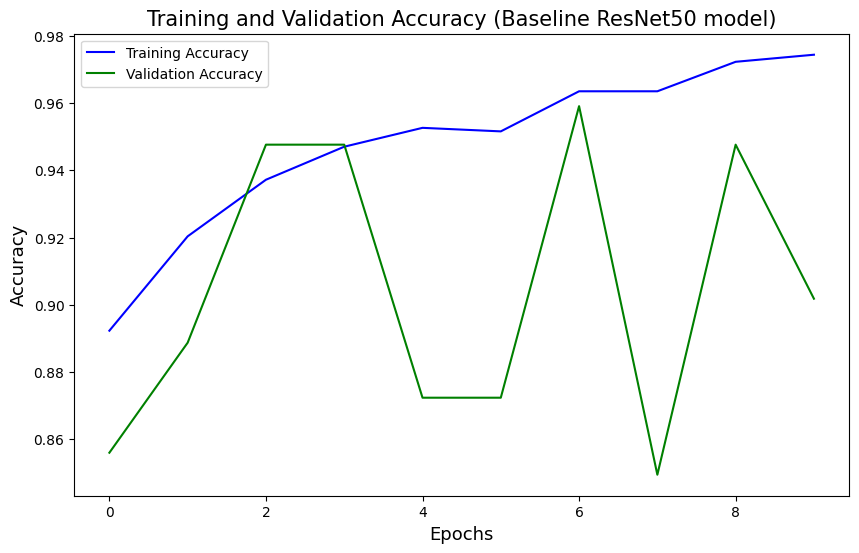

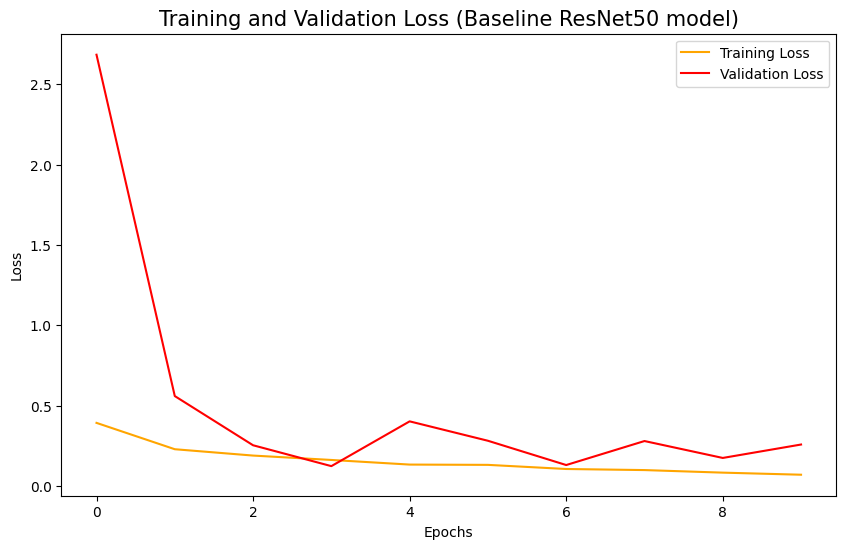

In [33]:
import matplotlib.pyplot as plt

# Plotting training and validation accuracies plot
plt.figure(figsize=(10, 6))
plt.plot(history_resnet_base.history['accuracy'], color="blue", label="Training Accuracy")
plt.plot(history_resnet_base.history['val_accuracy'], color="green", label="Validation Accuracy")
plt.xlabel("Epochs", fontsize=13)
plt.ylabel("Accuracy", fontsize=13)
plt.title("Training and Validation Accuracy (Baseline ResNet50 model)", fontsize=15)
plt.legend()
plt.show()

# Plotting training and validation loss plot
plt.figure(figsize=(10, 6))
plt.plot(history_resnet_base.history['loss'], color="orange", label="Training Loss")
plt.plot(history_resnet_base.history['val_loss'], color="red", label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss (Baseline ResNet50 model)", fontsize=15)
plt.legend()
plt.show()


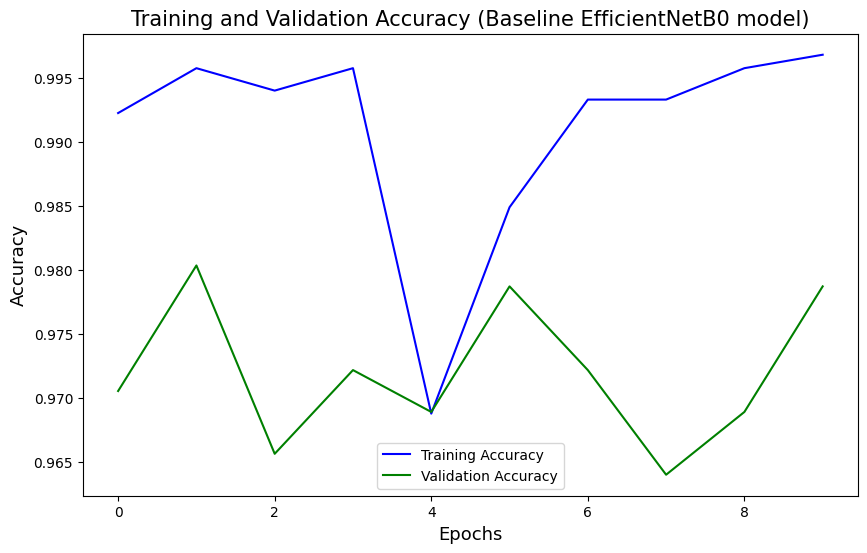

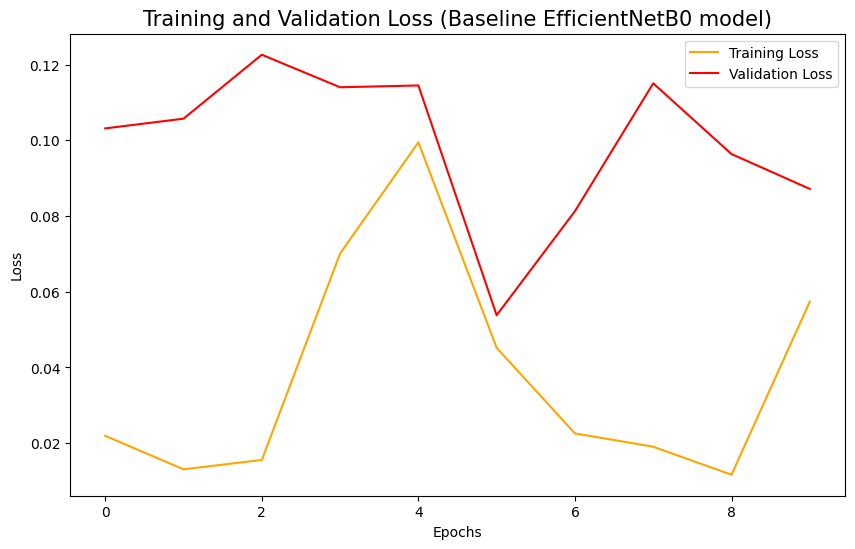

In [34]:
# Plotting training and validation accuracies plot
plt.figure(figsize=(10, 6))
plt.plot(history_efficientnet_base.history['accuracy'], color="blue", label="Training Accuracy")
plt.plot(history_efficientnet_base.history['val_accuracy'], color="green", label="Validation Accuracy")
plt.xlabel("Epochs", fontsize=13)
plt.ylabel("Accuracy", fontsize=13)
plt.title("Training and Validation Accuracy (Baseline EfficientNetB0 model)", fontsize=15)
plt.legend()
plt.show()

# Plotting training and validation loss plot
plt.figure(figsize=(10, 6))
plt.plot(history_efficientnet_base.history['loss'], color="orange", label="Training Loss")
plt.plot(history_efficientnet_base.history['val_loss'], color="red", label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss (Baseline EfficientNetB0 model)", fontsize=15)
plt.legend()
plt.show()

In [35]:
# Make predictions
predictions_resnet = model_resnet.predict(X_test)
predictions_effnet = model_efficientnet.predict(X_test)

# Convert predictions to labels
predictions_resnet = np.argmax(predictions_resnet, axis=1)
predictions_effnet = np.argmax(predictions_effnet, axis=1)

print("ResNet50 Predictions:", predictions_resnet)
print("EfficientNetB0 Predictions:", predictions_effnet)

20/20 ━━━━━━━━━━━━━━━━━━━━ 16s 799ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 331ms/step
ResNet50 Predictions: [0 0 1 0 1 0 1 1 0 0 0 1 1 1 0 0 0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0
 0 0 0 0 1 0 0 1 1 0 1 0 1 0 0 0 1 0 0 1 1 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0
 0 0 0 1 1 0 0 0 1 0 0 0 0 1 1 1 0 1 0 0 1 0 0 1 0 0 0 1 0 1 0 0 0 1 0 0 0
 0 0 1 0 0 1 0 0 0 0 0 0 0 1 1 1 0 1 0 0 0 0 0 1 0 0 0 1 1 1 1 0 0 0 0 0 0
 0 0 0 0 0 0 1 0 1 0 0 0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 1 0 1 1 0 0 0 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 0 0 0 0 0 0 0 0
 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
 1 1 0 1 0 0 1 0 0 0 0 1 1 0 0 0 0 1 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 1
 0 0 1 0 0 1 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 1 1 0 1 1 0 0 0 0 0
 0 0 1 0 0 0 0 1 0 1 0 1 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 1 0 1 0 0 0 0 0
 1 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0

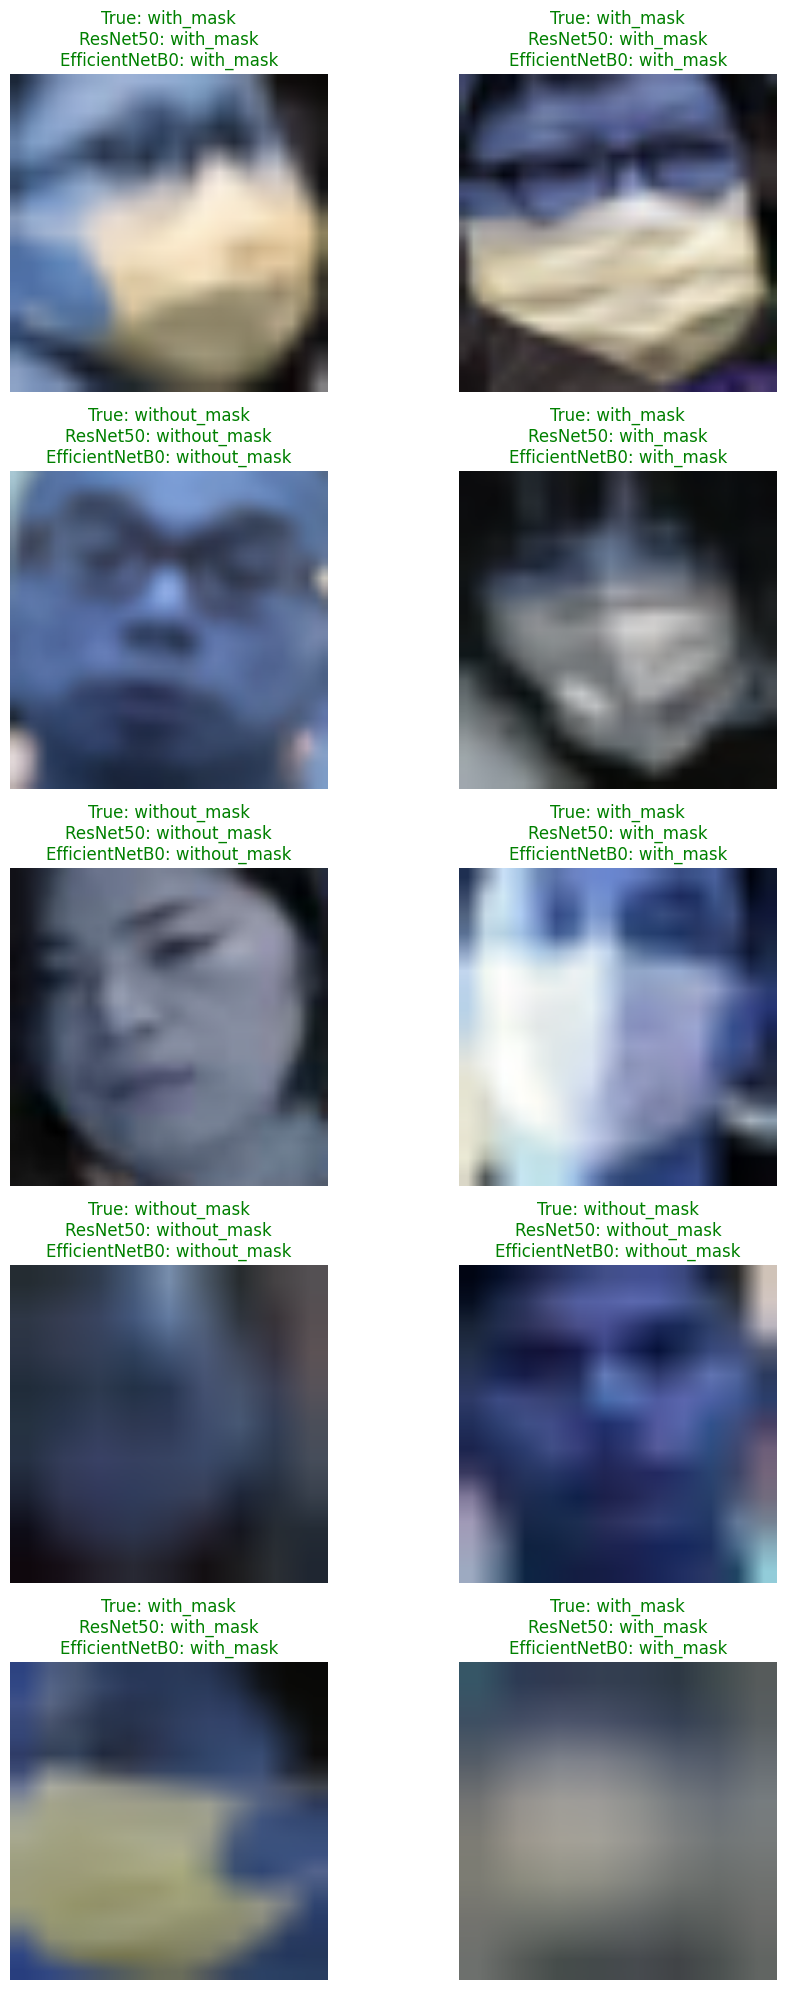

In [36]:
import matplotlib.pyplot as plt
import numpy as np

# Convert one-hot encoded labels back to label indices
y_test_indices = np.argmax(y_test, axis=1)

# Convert label indices back to original class names
y_test_names = label_encoder.inverse_transform(y_test_indices)

# Convert predicted label indices back to original class names
predictions_resnet_names = label_encoder.inverse_transform(predictions_resnet)
predictions_effnet_names = label_encoder.inverse_transform(predictions_effnet)

# Plot a random sample of images, true labels, and predicted labels
fig, axes = plt.subplots(5, 2, figsize=(10, 20))

for i, ax in enumerate(axes.flat):
    # Plot image
    ax.imshow(X_test[i])
    
    # Plot true and predicted labels
    true_label = y_test_names[i]
    predicted_label_resnet = predictions_resnet_names[i]
    predicted_label_effnet = predictions_effnet_names[i]
    
    title = ax.set_title(f"True: {true_label}\nResNet50: {predicted_label_resnet}\nEfficientNetB0: {predicted_label_effnet}")
    if predicted_label_resnet == predicted_label_effnet == true_label:
        title.set_color('green')
    else:
        title.set_color('red')
    ax.axis('off')

plt.tight_layout()
plt.show()


In [37]:
history_resnet_fine_tune = model_resnet_fine_tune.fit(train_dataset, validation_data=val_dataset, epochs=15)

Epoch 1/15
90/90 ━━━━━━━━━━━━━━━━━━━━ 548s 6s/step - accuracy: 0.8106 - loss: 0.8645 - val_accuracy: 0.5908 - val_loss: 1.9605
Epoch 2/15
90/90 ━━━━━━━━━━━━━━━━━━━━ 1623s 18s/step - accuracy: 0.9360 - loss: 0.2000 - val_accuracy: 0.7938 - val_loss: 0.4963
Epoch 3/15
90/90 ━━━━━━━━━━━━━━━━━━━━ 601s 7s/step - accuracy: 0.9377 - loss: 0.1877 - val_accuracy: 0.9427 - val_loss: 0.1523
Epoch 4/15
90/90 ━━━━━━━━━━━━━━━━━━━━ 475s 5s/step - accuracy: 0.9531 - loss: 0.1224 - val_accuracy: 0.8265 - val_loss: 0.7072
Epoch 5/15
90/90 ━━━━━━━━━━━━━━━━━━━━ 477s 5s/step - accuracy: 0.9316 - loss: 0.1862 - val_accuracy: 0.9083 - val_loss: 0.2455
Epoch 6/15
90/90 ━━━━━━━━━━━━━━━━━━━━ 489s 5s/step - accuracy: 0.9515 - loss: 0.1592 - val_accuracy: 0.7938 - val_loss: 9.5729
Epoch 7/15
90/90 ━━━━━━━━━━━━━━━━━━━━ 506s 6s/step - accuracy: 0.9474 - loss: 0.1409 - val_accuracy: 0.7938 - val_loss: 1.9943
Epoch 8/15
90/90 ━━━━━━━━━━━━━━━━━━━━ 517s 6s/step - accuracy: 0.9520 - loss: 0.1193 - val_accuracy: 0.7938 -

In [38]:
# Save the model - Resnet50 Fine tune
model_resnet_fine_tune.save('model_resnet_fine_tune.keras')

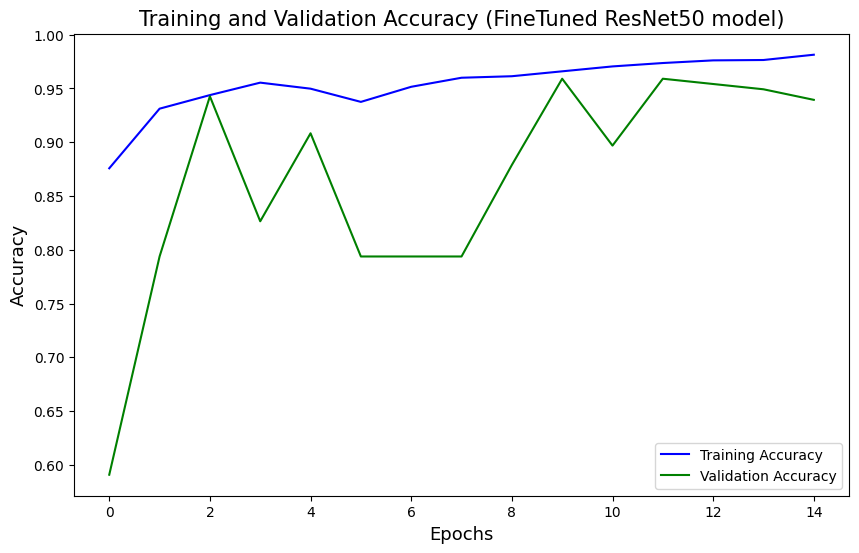

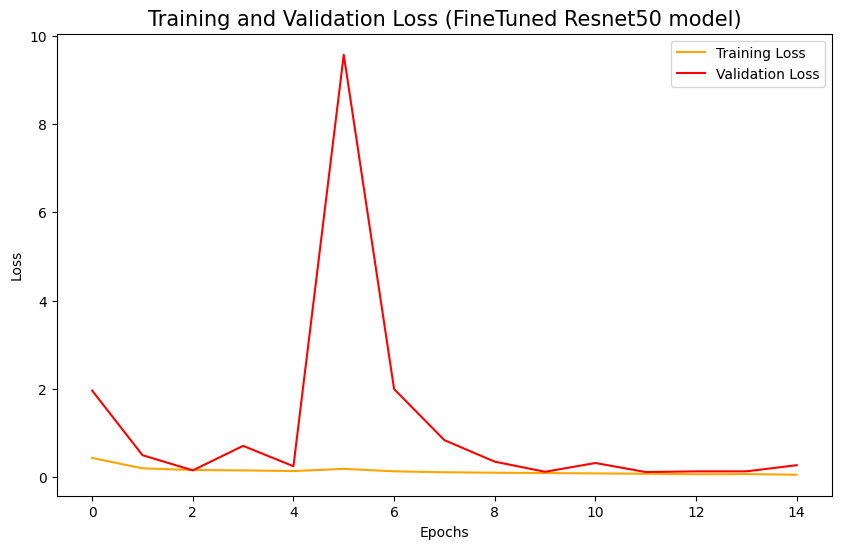

In [39]:
# Plotting training and validation accuracies plot
plt.figure(figsize=(10, 6))
plt.plot(history_resnet_fine_tune.history['accuracy'], color="blue", label="Training Accuracy")
plt.plot(history_resnet_fine_tune.history['val_accuracy'], color="green", label="Validation Accuracy")
plt.xlabel("Epochs", fontsize=13)
plt.ylabel("Accuracy", fontsize=13)
plt.title("Training and Validation Accuracy (FineTuned ResNet50 model)", fontsize=15)
plt.legend()
plt.show()

# Plotting training and validation loss plot
plt.figure(figsize=(10, 6))
plt.plot(history_resnet_fine_tune.history['loss'], color="orange", label="Training Loss")
plt.plot(history_resnet_fine_tune.history['val_loss'], color="red", label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss (FineTuned Resnet50 model)", fontsize=15)
plt.legend()
plt.show()

In [40]:
test_loss_resnet_fine_tune, test_accuracy_resnet_fine_tune = model_resnet_fine_tune.evaluate(X_test, y_test)
print(f"Test Loss for Fine Tuned Resnet Model: {test_loss_resnet_fine_tune*100:.2f}%")
print(f"Test Accuracy for Fine Tuned Resnet Model: {test_accuracy_resnet_fine_tune*100:.2f}%")

20/20 ━━━━━━━━━━━━━━━━━━━━ 16s 743ms/step - accuracy: 0.9309 - loss: 0.3280
Test Loss for Fine Tuned Resnet Model: 24.39%
Test Accuracy for Fine Tuned Resnet Model: 94.27%


In [41]:
# Make predictions
predictions_resnet_fine_tune = model_resnet_fine_tune.predict(X_test)

# Convert predictions to labels
predictions_resnet_fine_tune = np.argmax(predictions_resnet_fine_tune, axis=1)

print("Fine Tuned ResNet50 Predictions:", predictions_resnet_fine_tune)

20/20 ━━━━━━━━━━━━━━━━━━━━ 17s 802ms/step
Fine Tuned ResNet50 Predictions: [0 0 1 0 1 0 1 1 0 0 0 1 1 1 0 0 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
 1 0 0 0 1 0 0 1 1 0 1 0 1 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 1 1 0 0 1 1 0 0 0
 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 1 0 0 1 0 0 0 0 1 0 0 1 1 0 0 0 0 0 1 0 0 1
 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 1 1 1 1 0 0 0 0 0 0
 0 0 0 0 0 0 1 0 1 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 1 0 0 0 0 0 1 0 1 0 1 1 0 0 0 1 1 0 0 0 0 0 0 1 1 0 0 0 0 0 0 1 0
 0 1 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
 1 1 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 1 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 1 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 0 0 1 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 1 0 1 1 0 0 1 1 0 0 1 0 0
 0 0 1 0 0 0 1 0 0 1 0 1 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 1 0 0 0 0 0 0 1
 1 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 0 0 0 

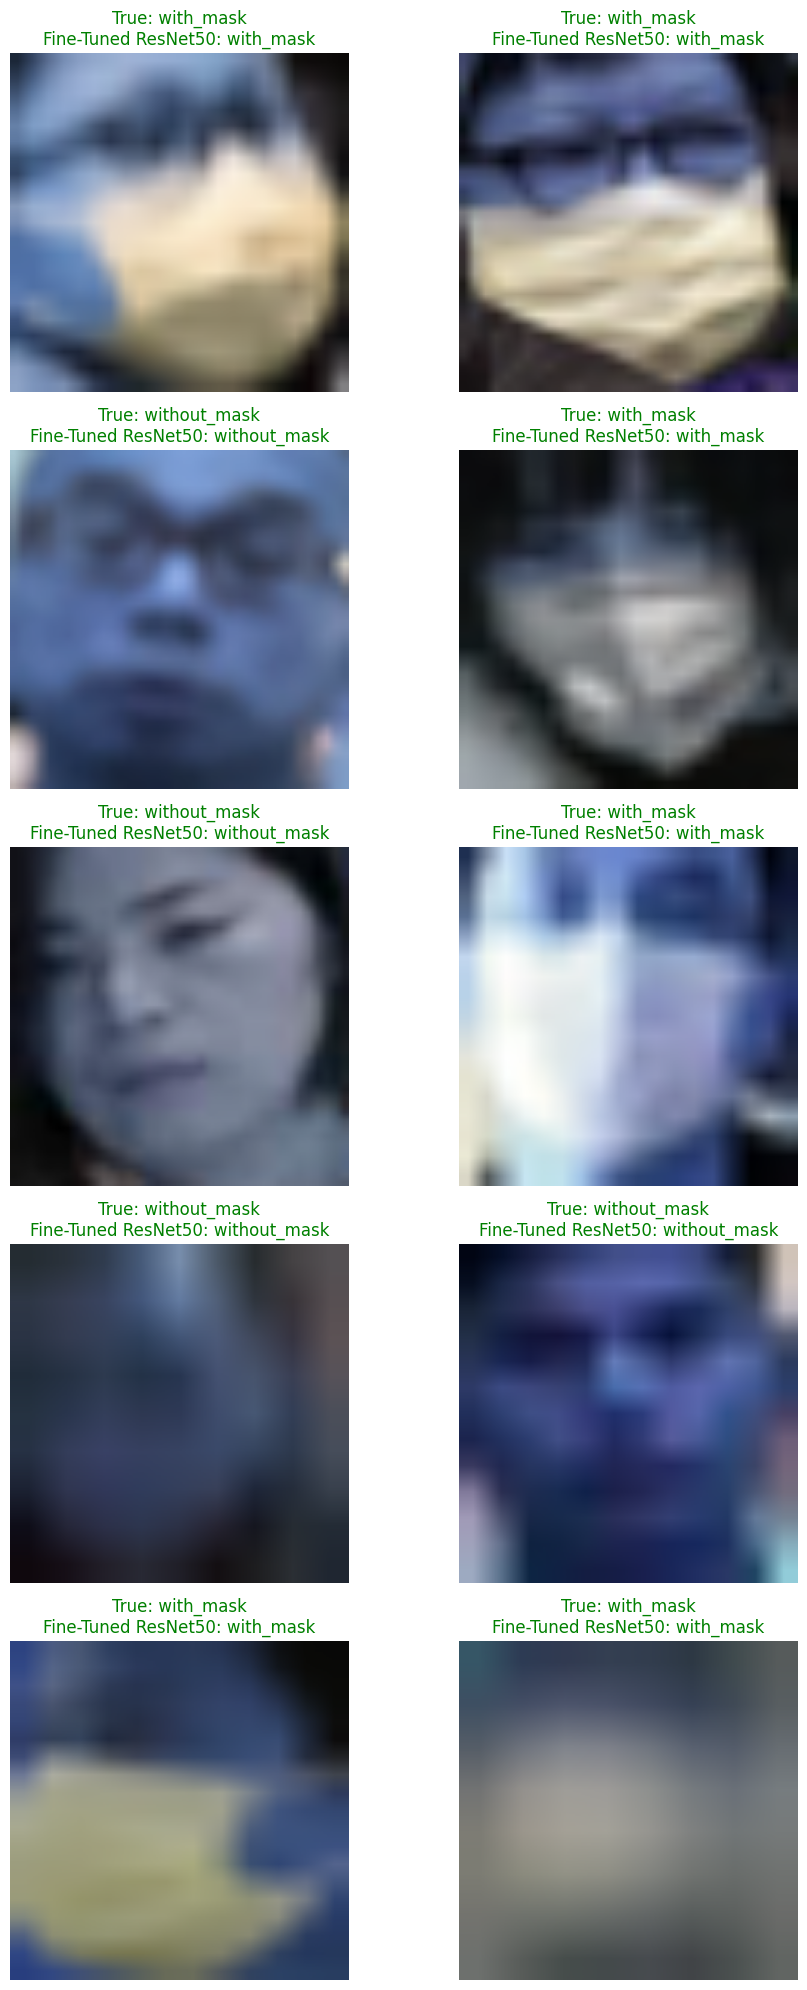

In [42]:
import matplotlib.pyplot as plt
import numpy as np

# Convert one-hot encoded labels back to label indices
y_test_indices = np.argmax(y_test, axis=1)

# Convert label indices back to original class names
y_test_names = label_encoder.inverse_transform(y_test_indices)

# Convert predicted label indices back to original class names
predictions_resnet_fine_tune_names = label_encoder.inverse_transform(predictions_resnet_fine_tune)

# Plot a random sample of images, true labels, and predicted labels
fig, axes = plt.subplots(5, 2, figsize=(10, 20))

for i, ax in enumerate(axes.flat):
    # Plot image
    ax.imshow(X_test[i])
    
    # Plot true and predicted labels
    true_label = y_test_names[i]
    predicted_label_resnet_fine_tune = predictions_resnet_fine_tune_names[i]
    
    title = ax.set_title(f"True: {true_label}\nFine-Tuned ResNet50: {predicted_label_resnet_fine_tune}")
    if predicted_label_resnet_fine_tune == true_label:
        title.set_color('green')
    else:
        title.set_color('red')
    ax.axis('off')
    
plt.tight_layout()
plt.show()

In [43]:
history_efficient_fine_tune = model_efficientnet_fine_tune.fit(train_dataset, validation_data=val_dataset, epochs=15)

Epoch 1/15
90/90 ━━━━━━━━━━━━━━━━━━━━ 242s 3s/step - accuracy: 0.8679 - loss: 0.3205 - val_accuracy: 0.8756 - val_loss: 0.4039
Epoch 2/15
90/90 ━━━━━━━━━━━━━━━━━━━━ 269s 3s/step - accuracy: 0.9664 - loss: 0.1074 - val_accuracy: 0.8871 - val_loss: 0.3766
Epoch 3/15
90/90 ━━━━━━━━━━━━━━━━━━━━ 264s 3s/step - accuracy: 0.9740 - loss: 0.1057 - val_accuracy: 0.9509 - val_loss: 0.2192
Epoch 4/15
90/90 ━━━━━━━━━━━━━━━━━━━━ 269s 3s/step - accuracy: 0.9776 - loss: 0.0715 - val_accuracy: 0.9607 - val_loss: 0.1267
Epoch 5/15
90/90 ━━━━━━━━━━━━━━━━━━━━ 263s 3s/step - accuracy: 0.9801 - loss: 0.0693 - val_accuracy: 0.9705 - val_loss: 0.1090
Epoch 6/15
90/90 ━━━━━━━━━━━━━━━━━━━━ 257s 3s/step - accuracy: 0.9854 - loss: 0.0393 - val_accuracy: 0.9460 - val_loss: 0.2704
Epoch 7/15
90/90 ━━━━━━━━━━━━━━━━━━━━ 266s 3s/step - accuracy: 0.9865 - loss: 0.0407 - val_accuracy: 0.9656 - val_loss: 0.1361
Epoch 8/15
90/90 ━━━━━━━━━━━━━━━━━━━━ 269s 3s/step - accuracy: 0.9903 - loss: 0.0261 - val_accuracy: 0.9722 - v

In [44]:
# Save the model - EfficientNetB0 Fine tune
model_efficientnet_fine_tune.save('model_efficientnet_fine_tune.keras')

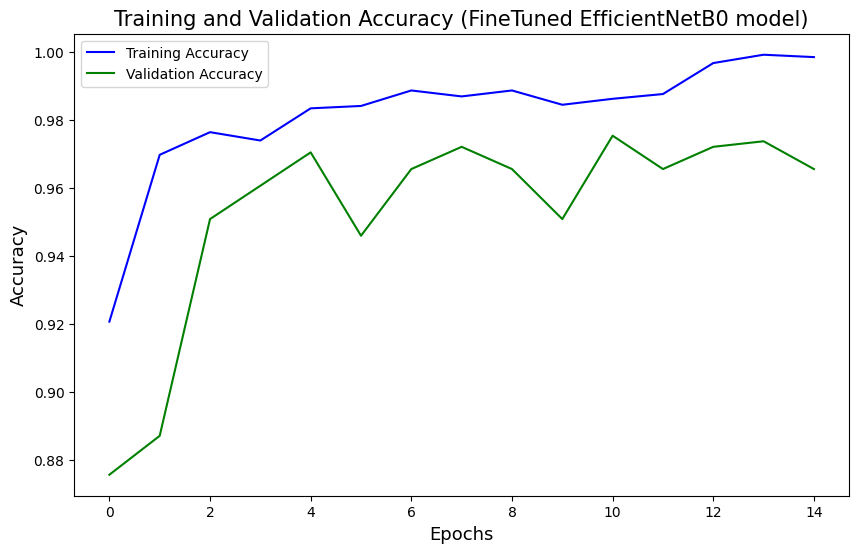

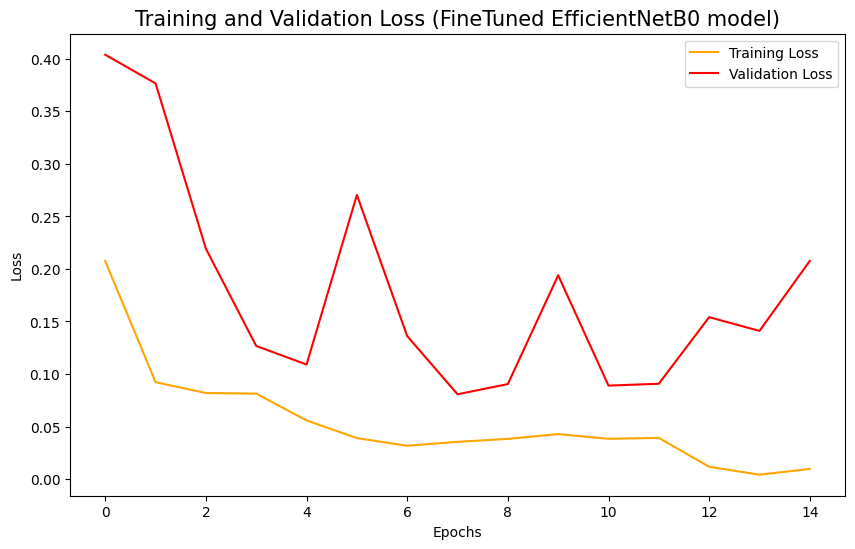

In [45]:
# Plotting training and validation accuracies plot
plt.figure(figsize=(10, 6))
plt.plot(history_efficient_fine_tune.history['accuracy'], color="blue", label="Training Accuracy")
plt.plot(history_efficient_fine_tune.history['val_accuracy'], color="green", label="Validation Accuracy")
plt.xlabel("Epochs", fontsize=13)
plt.ylabel("Accuracy", fontsize=13)
plt.title("Training and Validation Accuracy (FineTuned EfficientNetB0 model)", fontsize=15)
plt.legend()
plt.show()

# Plotting training and validation loss plot
plt.figure(figsize=(10, 6))
plt.plot(history_efficient_fine_tune.history['loss'], color="orange", label="Training Loss")
plt.plot(history_efficient_fine_tune.history['val_loss'], color="red", label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss (FineTuned EfficientNetB0 model)", fontsize=15)
plt.legend()
plt.show()

In [46]:
test_loss_efficientnet_fine_tune, test_accuracy_efficientnet_fine_tune = model_efficientnet_fine_tune.evaluate(X_test, y_test)
print(f"Test Loss for Fine Tuned EfficientNetB0 Model: {test_loss_efficientnet_fine_tune*100:.2f}%")
print(f"Test Accuracy for Fine Tuned EfficientNetB0 Model: {test_accuracy_efficientnet_fine_tune*100:.2f}%")

20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 292ms/step - accuracy: 0.9861 - loss: 0.1476
Test Loss for Fine Tuned EfficientNetB0 Model: 10.71%
Test Accuracy for Fine Tuned EfficientNetB0 Model: 98.53%


In [47]:
# Make predictions
predictions_efficientnet_fine_tune = model_efficientnet_fine_tune.predict(X_test)

# Convert predictions to labels
predictions_efficientnet_fine_tune = np.argmax(predictions_efficientnet_fine_tune, axis=1)

print("Fine Tuned EfficientNetB0 Predictions:", predictions_efficientnet_fine_tune)

20/20 ━━━━━━━━━━━━━━━━━━━━ 10s 340ms/step
Fine Tuned EfficientNetB0 Predictions: [0 0 1 0 1 0 1 1 0 0 0 1 1 1 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0
 0 0 0 0 1 0 0 1 1 0 0 0 1 0 0 0 1 1 0 1 1 0 0 0 0 1 0 0 0 1 0 0 1 0 0 0 0
 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 1 0 0 1
 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 1 1 1 1 0 0 0 0 0 0
 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0
 0 1 0 1 1 0 0 0 0 0 1 0 1 0 1 0 0 0 0 1 1 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0
 0 1 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
 1 1 0 1 0 0 1 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 1 0 0 1 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 0 0 1 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 1 0 0 1 1 0 0 1 0 0
 0 0 1 0 0 0 1 0 0 1 0 1 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 1 0 0 0 0 0 0 1
 1 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 

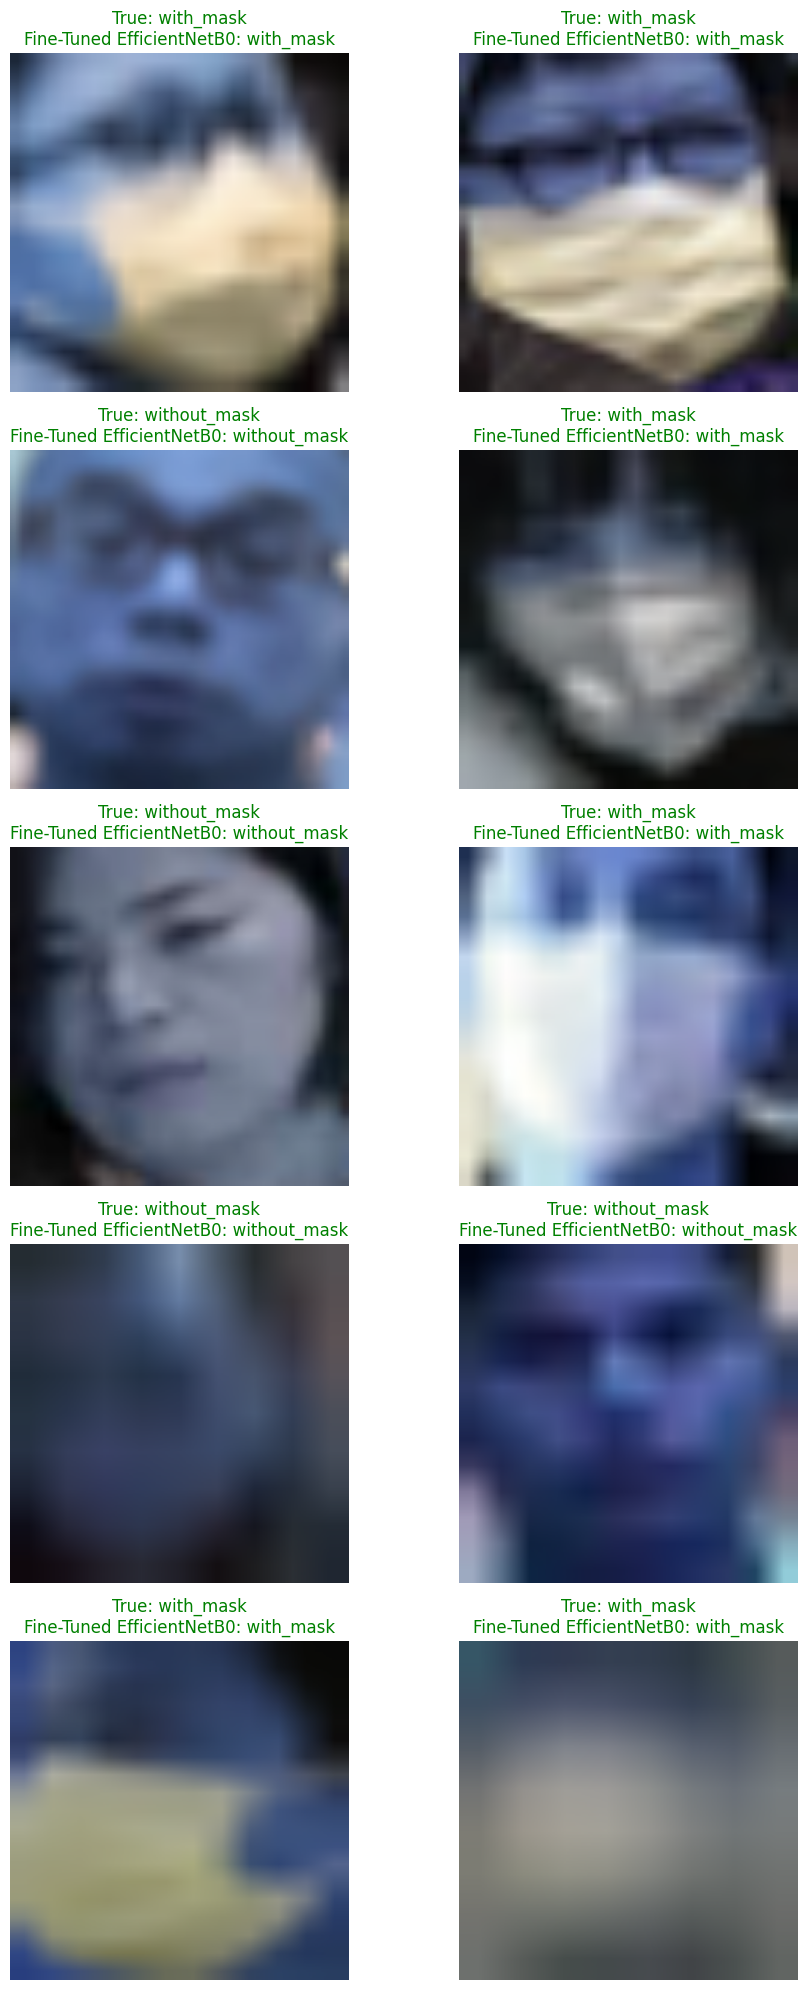

In [48]:
import matplotlib.pyplot as plt
import numpy as np

# Convert one-hot encoded labels back to label indices
y_test_indices = np.argmax(y_test, axis=1)

# Convert label indices back to original class names
y_test_names = label_encoder.inverse_transform(y_test_indices)

# Convert predicted label indices back to original class names
predictions_efficientnet_fine_tune_names = label_encoder.inverse_transform(predictions_efficientnet_fine_tune)

# Plot a random sample of images, true labels, and predicted labels
fig, axes = plt.subplots(5, 2, figsize=(10, 20))

for i, ax in enumerate(axes.flat):
    # Plot image
    ax.imshow(X_test[i])
    
    # Plot true and predicted labels
    true_label = y_test_names[i]
    predicted_label_efficientnet_fine_tune = predictions_efficientnet_fine_tune_names[i]
    
    title = ax.set_title(f"True: {true_label}\nFine-Tuned EfficientNetB0: {predicted_label_efficientnet_fine_tune}")
    if predicted_label_efficientnet_fine_tune == true_label:
        title.set_color('green')
    else:
        title.set_color('red')
    ax.axis('off')

plt.tight_layout()
plt.show()